# Baseline

## Load and prepare data

In [53]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


import os

In [54]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

KeyboardInterrupt: 

In [ ]:
for s in range(50):
    print(train_data[s][0][0][0])

338.59322191910144
3141.1610733749867
277.5519818788174
5120.083908238015
151.68348216686076
1520.9112447782634
-1439.4765481150055
5484.016233294116
2943.118961848223
6812.775120286165
185.86787279036292
2630.287139674461
4542.4441756807255
2778.157298010482
3627.084088281751
3186.7664771910886
-741.0554175008206
6328.087336589542
3550.3901494954252
68.06889174094954
-300.52460006352146
2125.2141405718635
9517.177395754596
2968.537095963221
5164.223747137092
-1843.0614330799417
65.07074334965716
-600.6842620243576
2727.341672086217
257.89922502315545
-1779.5356765821361
4350.571242314503
-71.89738594550053
6480.391285998383
5565.927991722484
5555.654290754947
706.9439124393834
2827.9448918858707
3309.1973443253605
2792.3367926294777
3886.133915491251
4142.802890686185
18.45852602295149
-607.5022219701269
5553.428861734927
5725.730263934792
2182.0290689771823
6413.496097240114
5372.206181399366
548.208257121106


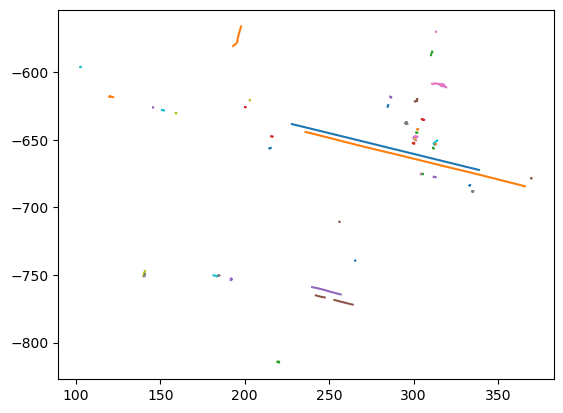

In [ ]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

In [ ]:
# say you have a model trained. we write a dummy model just to show usage

def dummy_model(input_data):
    return np.ones((2100, 1, 60, 2))


output = dummy_model(test_data)
output.shape

(2100, 1, 60, 2)

In [ ]:
# reshape to fit desired format: (2100, 1, 60, 2) -> (12600, 2)
dummy_output = output.reshape(-1, 2)
output_df = pd.DataFrame(dummy_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('dummy_submission.csv')

## Simple MLP

In [ ]:
# Split x and y for train data.

train_x, train_y = train_data[:, :, :50, :], train_data[:, 0, 50:, :2]

print(train_x.shape, train_y.shape)

(10000, 50, 50, 6) (10000, 60, 2)


In [ ]:

class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()

        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x


In [ ]:
# Calculate the total number of features after flattening
input_features = 50 * 50 * 6  # = 15000
output_features = 60 * 2

# Create the model
simple_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(simple_model.parameters(), lr=0.001)


In [ ]:
# Example of how to prepare data and train the model

def train_model(model, train_x, train_y, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    print(X_train_tensor.shape)
    print(y_train_tensor.shape)

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in tqdm(train_loader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
    return model


In [ ]:
simple_model = train_model(simple_model, train_x, train_y)

torch.Size([10000, 15000])
torch.Size([10000, 120])


100%|██████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 1, Loss: 881208.6087


100%|██████████| 157/157 [00:22<00:00,  7.03it/s]


Epoch 2, Loss: 327127.6840


100%|██████████| 157/157 [00:20<00:00,  7.70it/s]


Epoch 3, Loss: 235649.2520


100%|██████████| 157/157 [00:20<00:00,  7.64it/s]


Epoch 4, Loss: 231455.6176


100%|██████████| 157/157 [00:21<00:00,  7.37it/s]


Epoch 5, Loss: 215819.8926


100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


Epoch 6, Loss: 250712.6843


100%|██████████| 157/157 [00:19<00:00,  8.02it/s]


Epoch 7, Loss: 214834.2305


100%|██████████| 157/157 [00:20<00:00,  7.55it/s]


Epoch 8, Loss: 247021.6875


100%|██████████| 157/157 [00:20<00:00,  7.49it/s]


Epoch 9, Loss: 178459.0109


100%|██████████| 157/157 [00:20<00:00,  7.64it/s]


Epoch 10, Loss: 201185.7981


In [ ]:

def predict(model, X_test):
    """Make predictions with the trained model"""
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features))
        predictions = model(X_test_tensor).reshape((-1, 60, 2))
    return predictions.numpy()

# Save model
def save_model(model, path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

# Load model
def load_model(path="mlp_model.pth"):
    loaded_model = MLP()
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model

In [ ]:
# train loss

# Predict on training data
train_pred_y = predict(simple_model, train_x)

# Compute mean squared error between predicted and true future trajectories
mlp_mse = ((train_pred_y - train_y) ** 2).mean()
print(f"Simple MLP model train MSE: {mlp_mse:.4f}")

Simple MLP model train MSE: 104943.0821


In [ ]:
print(f'train_x shape: {train_x.shape}')
print(f'train_pred_y shape: {train_pred_y.shape}')
print(f'train_y shape: {train_y.shape}')

train_x shape: (10000, 50, 50, 6)
train_pred_y shape: (10000, 60, 2)
train_y shape: (10000, 60, 2)


In [ ]:
# Check one prediction vs true value
i = 0
print("Predicted:", train_pred_y[i, :5])  # First 5 steps
print("Ground truth:", train_y[i, :5])

Predicted: [[ 287.38553 -611.02747]
 [ 283.4844  -609.6404 ]
 [ 300.98788 -625.56537]
 [ 292.9798  -620.84015]
 [ 309.76144 -599.1161 ]]
Ground truth: [[ 287.20506697 -656.44786782]
 [ 286.15194295 -656.12434684]
 [ 285.09779188 -655.8001401 ]
 [ 284.04323995 -655.47571797]
 [ 282.98837762 -655.15099393]]


In [ ]:

pred_y = predict(simple_model, test_data)

pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

# adding a necessary step to match index of your prediction to that of the solution key

output_df.index.name = 'index'

output_df.to_csv('mlp_baseline.csv')

 # Now you can submit to the leaderboard!

# SHANTIH MLP

# Taking just the x, y as input

In [ ]:
train_x, train_y = train_data[:, :, :50, :2], train_data[:, 0, 50:, :2]

print(train_x.shape, train_y.shape)

# Calculate the total number of features after flattening
input_features = 50 * 50 * 2  # = 5000
output_features = 60 * 2

pos_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(pos_model.parameters(), lr=0.001)

(10000, 50, 50, 2) (10000, 60, 2)


In [ ]:
pos_model = train_model(pos_model, train_x, train_y)

torch.Size([10000, 5000])
torch.Size([10000, 120])


100%|██████████| 157/157 [00:08<00:00, 18.17it/s]


Epoch 1, Loss: 818656.2593


100%|██████████| 157/157 [00:09<00:00, 16.79it/s]


Epoch 2, Loss: 328710.1956


100%|██████████| 157/157 [00:07<00:00, 22.07it/s]


Epoch 3, Loss: 271412.3518


100%|██████████| 157/157 [00:07<00:00, 22.39it/s]


Epoch 4, Loss: 214101.8230


100%|██████████| 157/157 [00:06<00:00, 22.45it/s]


Epoch 5, Loss: 215431.4034


100%|██████████| 157/157 [00:07<00:00, 21.87it/s]


Epoch 6, Loss: 267139.8893


100%|██████████| 157/157 [00:09<00:00, 17.43it/s]


Epoch 7, Loss: 217641.2600


100%|██████████| 157/157 [00:09<00:00, 16.33it/s]


Epoch 8, Loss: 194271.5078


100%|██████████| 157/157 [00:07<00:00, 19.79it/s]


Epoch 9, Loss: 175669.3564


100%|██████████| 157/157 [00:08<00:00, 18.35it/s]


Epoch 10, Loss: 151924.2085


In [ ]:
train_pred_y = predict(pos_model, train_x)

# Compute mean squared error between predicted and true future trajectories
mlp_mse = ((train_pred_y - train_y) ** 2).mean()
print(f"MLP model train MSE: {mlp_mse:.4f}")

MLP model train MSE: 165880.8008


# Using just the ego

In [ ]:
train_x, train_y = train_data[:, 0, :50, :2], train_data[:, 0, 50:, :2]

print(train_x.shape, train_y.shape)

# Calculate the total number of features after flattening
input_features = 50 * 2  # = 100
output_features = 60 * 2

ego_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(ego_model.parameters(), lr=0.001)

(10000, 50, 2) (10000, 60, 2)


In [ ]:
ego_model = train_model(ego_model, train_x, train_y)

torch.Size([10000, 100])
torch.Size([10000, 120])


100%|██████████| 157/157 [00:01<00:00, 119.61it/s]


Epoch 1, Loss: 602073.4793


100%|██████████| 157/157 [00:01<00:00, 134.27it/s]


Epoch 2, Loss: 143305.9692


100%|██████████| 157/157 [00:01<00:00, 137.41it/s]


Epoch 3, Loss: 107230.8281


100%|██████████| 157/157 [00:01<00:00, 101.59it/s]


Epoch 4, Loss: 131723.8611


100%|██████████| 157/157 [00:01<00:00, 98.04it/s] 


Epoch 5, Loss: 133177.1938


100%|██████████| 157/157 [00:01<00:00, 99.81it/s] 


Epoch 6, Loss: 96822.9371


100%|██████████| 157/157 [00:01<00:00, 110.58it/s]


Epoch 7, Loss: 116843.7296


100%|██████████| 157/157 [00:01<00:00, 120.89it/s]


Epoch 8, Loss: 92490.9523


100%|██████████| 157/157 [00:01<00:00, 102.59it/s]


Epoch 9, Loss: 86938.2755


100%|██████████| 157/157 [00:01<00:00, 84.33it/s]

Epoch 10, Loss: 91513.7790


In [ ]:
train_pred_y = predict(ego_model, train_x)

# Compute mean squared error between predicted and true future trajectories
mlp_mse = ((train_pred_y - train_y) ** 2).mean()
print(f"MLP model train MSE: {mlp_mse:.4f}")

MLP model train MSE: 9339.2535


# Normalized

In [ ]:
train_x, train_y = train_data[:, 0, :50, :2], train_data[:, 0, 50:, :2]
initial_x, initial_y = train_x[:, 0:1, :].copy(), train_y[:, 0:1, :].copy()
train_x -= initial_x
train_y -= initial_y

print(train_x.shape, train_y.shape)

# Calculate the total number of features after flattening
input_features = 50 * 2  # = 100
output_features = 60 * 2

norm_model = MLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()  # For regression task

optimizer = optim.Adam(norm_model.parameters(), lr=0.001)

(10000, 50, 2) (10000, 60, 2)


In [ ]:
norm_model = train_model(norm_model, train_x, train_y)

torch.Size([10000, 100])
torch.Size([10000, 120])


100%|██████████| 157/157 [00:01<00:00, 123.48it/s]


Epoch 1, Loss: 62.0360


100%|██████████| 157/157 [00:01<00:00, 136.52it/s]


Epoch 2, Loss: 38.9814


100%|██████████| 157/157 [00:01<00:00, 110.76it/s]


Epoch 3, Loss: 35.0662


100%|██████████| 157/157 [00:01<00:00, 100.95it/s]


Epoch 4, Loss: 33.7527


100%|██████████| 157/157 [00:01<00:00, 116.16it/s]


Epoch 5, Loss: 31.2684


100%|██████████| 157/157 [00:01<00:00, 110.27it/s]


Epoch 6, Loss: 31.6507


100%|██████████| 157/157 [00:01<00:00, 109.42it/s]


Epoch 7, Loss: 30.3936


100%|██████████| 157/157 [00:01<00:00, 109.46it/s]


Epoch 8, Loss: 29.7717


100%|██████████| 157/157 [00:01<00:00, 96.46it/s] 


Epoch 9, Loss: 28.4794


100%|██████████| 157/157 [00:01<00:00, 108.99it/s]

Epoch 10, Loss: 28.3565


In [ ]:
train_pred_y = predict(norm_model, train_x)

# Compute mean squared error between predicted and true future trajectories
mlp_mse = ((train_pred_y - train_y) ** 2).mean()
print(f"MLP model train MSE: {mlp_mse:.4f}")

MLP model train MSE: 24.0053


# CODE TO START NORMALIZING TEST AND RUN ALL

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import os

In [2]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


### Test data

In [29]:
# FORGOT WE DONT HAVE LABELS FOR TEST LOL
test_data = test_file['data']
test_x = test_data[:, 0, :50, :2]
initial_test_x = test_x[:, 0:1, :].copy()
test_x -= initial_test_x

print(test_x.shape)

(2100, 50, 2)


### Code for autoregressive stuff

In [4]:
num_features = 50
num_labels = 10

def do_autoregressive(train_data, num_features, num_labels):
    ar_train_x, ar_train_y = [], []

    for s in range(train_data.shape[0]):
        for p in range(num_features, 110 - num_labels):
            train_x, train_y = train_data[s, 0, p-num_features:p, :2], train_data[s, 0, p:p+num_labels, :2] 
            initial_train_x, = train_x[0:1, :].copy()
            train_x -= initial_train_x
            train_y -= initial_train_x
            ar_train_x.append(train_x)
            ar_train_y.append(train_y)
    ar_train_x = np.stack(ar_train_x, axis=0)
    ar_train_y = np.stack(ar_train_y, axis=0)
    return ar_train_x, ar_train_y

### Training and validation sets

In [5]:
auto_regressive = True

train_x, train_y = train_data[:, 0, :50, :2], train_data[:, 0, 50:, :2]
initial_train_x, initial_train_y = train_x[:, 0:1, :].copy(), train_y[:, 0:1, :].copy()
train_x -= initial_train_x
train_y -= initial_train_x

print(train_x.shape)

if auto_regressive:
    train_x, train_y = do_autoregressive(train_data, num_features, num_labels)
    print(train_x.shape, train_y.shape)

ratio_validation = 0.2
perm = torch.randperm(train_x.shape[0])
idx = int(ratio_validation * train_x.shape[0])

new_train_x = train_x[perm[idx:]]
new_train_y = train_y[perm[idx:]]

val_x = train_x[perm[:idx]]
val_y = train_y[perm[:idx]]

print(train_x.shape, train_y.shape)
print(new_train_x.shape, new_train_y.shape)
print(val_x.shape, val_y.shape)

(10000, 50, 2)
(500000, 50, 2) (500000, 10, 2)
(500000, 50, 2) (500000, 10, 2)
(400000, 50, 2) (400000, 10, 2)
(100000, 50, 2) (100000, 10, 2)


### Code for adding closest agent feature (in progress)

In [6]:
def dist(x1, y1, x2, y2):
    return Math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def add_closest_agent(x):
    #x is the features.
    #I want to take them from (num_scenes, num_agents, num_timesteps, num_dimensions) to (num_scenes, num_timesteps, num_dimensions * 2) by adding the dimensions of the closest agent

    new_x = []
    for s in x.shape[0]:
        each_scene = []
        for t in x.shape[2]:
            ca = 1
            for a in x.shape[1]:
                if dist(x[s][0][t][0], x[s][0][t][1], x[s][a][t][0], x[s][a][t][1]) < dist(x[s][0][t][0], x[s][0][t][1], x[s][ca][t][0], x[s][ca][t][1]):
                    ca = a
            each_scene.append([x[s][0][t][0], x[s][0][t][1], x[s][ca][t][0], x[s][ca][t][1]])
        new_x.append(each_scene)

    return new_x

In [7]:
class ComplexMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(ComplexMLP, self).__init__()

        # Define the layers
        self.input_features = input_features
        self.output_features = output_features
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(1024, 1024),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(1024, 512),
            nn.ReLU(),
            #nn.Dropout(0.1),

            nn.Linear(512, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x

In [8]:
def predict(model, x):
    model.eval()
    with torch.no_grad():
        print(input_features, output_features, output_features / 2)
        x_tensor = torch.FloatTensor(x).reshape((-1, input_features))
        predictions = model(x_tensor).reshape((-1, int(output_features / 2), 2))
        return predictions.numpy()


In [9]:
def evaluate_model(model, x, y, dataset):
    pred_y = predict(model, x)
        
    mse = ((pred_y - y) ** 2).mean()
    print("Model MSE evaluated on", dataset, ":", mse.item())
    return mse

In [10]:
# Example of how to prepare data and train the model

def new_train_model(model, criterion, optimizer, train_x, train_y, val_x, val_y, batch_size=64, epochs=10):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, model.input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, model.output_features))
    print(X_train_tensor.shape)
    print(y_train_tensor.shape)

    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0

        for batch_X, batch_y in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)

            # Calculate loss
            loss = criterion(outputs, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print epoch statistics
        #print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}')
        evaluate_model(model, train_x, train_y, "TRAIN")
        evaluate_model(model, val_x, val_y, "VALIDATION")

    return model


In [11]:
input_features = 50 * 2  # = 100
output_features = 60 * 2

if auto_regressive:
    input_features = num_features * 2
    output_features = num_labels * 2

print(input_features, output_features)

norm_model = ComplexMLP(input_features, output_features)

# Define loss function and optimizer
criterion = nn.MSELoss()

optimizer = optim.Adam(norm_model.parameters(), lr=0.001)

norm_model = new_train_model(norm_model, criterion, optimizer, new_train_x, new_train_y, val_x, val_y, batch_size=64, epochs=20)

100 20
torch.Size([400000, 100])
torch.Size([400000, 20])
Epoch 1, Loss: 3.3900
100 20 10.0
Model MSE evaluated on TRAIN : 1.0828152877139652
100 20 10.0
Model MSE evaluated on VALIDATION : 1.0743849798671727
Epoch 2, Loss: 1.4226
100 20 10.0
Model MSE evaluated on TRAIN : 0.8946436561768514
100 20 10.0
Model MSE evaluated on VALIDATION : 0.8866487318935139
Epoch 3, Loss: 0.9329
100 20 10.0
Model MSE evaluated on TRAIN : 0.9747986184621523
100 20 10.0
Model MSE evaluated on VALIDATION : 0.9693825974833505
Epoch 4, Loss: 0.8040
100 20 10.0
Model MSE evaluated on TRAIN : 0.7465484780693817
100 20 10.0
Model MSE evaluated on VALIDATION : 0.7460102568266834
Epoch 5, Loss: 0.7042
100 20 10.0
Model MSE evaluated on TRAIN : 0.6077719392221514
100 20 10.0
Model MSE evaluated on VALIDATION : 0.6049964269061965
Epoch 6, Loss: 0.6305
100 20 10.0
Model MSE evaluated on TRAIN : 0.7581213748297403
100 20 10.0
Model MSE evaluated on VALIDATION : 0.7522217850506681
Epoch 7, Loss: 0.5943
100 20 10.0
Mo

KeyboardInterrupt: 

In [12]:
evaluate_model(norm_model, train_x, train_y, "TRAIN")
evaluate_model(norm_model, val_x, val_y, "VALIDATION")

100 20 10.0
Model MSE evaluated on TRAIN : 0.3644307232142692
100 20 10.0
Model MSE evaluated on VALIDATION : 0.36405780795426457


0.36405780795426457

In [54]:
def ar_inference(norm_model, feature):
    print('in', feature.shape)
    answer = []
    for i in range(int(60 / num_labels)):
        pred = predict(norm_model, feature)
        answer.append(pred)
        feature = np.concatenate((feature, pred), axis=1)
        feature = feature[:, -num_features:, :]
    answer = np.concatenate(answer, axis=1)
    return answer

In [55]:
print(test_x.shape)
if not auto_regressive:
    pred_y = predict(norm_model, test_x)
else:
    pred_y = ar_inference(norm_model, test_x)

pred_y += initial_test_x

# Code to write the prediction to file
pred_output = pred_y.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])

output_df.index.name = 'index'

output_df.to_csv('shantih_mlp.csv')

(2100, 50, 2)
in (2100, 50, 2)
100 20 10.0
100 20 10.0
100 20 10.0
100 20 10.0
100 20 10.0
100 20 10.0
